In [1]:
version

               _                           
platform       x86_64-apple-darwin14.5.0   
arch           x86_64                      
os             darwin14.5.0                
system         x86_64, darwin14.5.0        
status                                     
major          3                           
minor          4.1                         
year           2017                        
month          06                          
day            30                          
svn rev        72865                       
language       R                           
version.string R version 3.4.1 (2017-06-30)
nickname       Single Candle               

# Load packages

In [2]:
library(optimx)         
library(FD)       
library(snow)     # (if you want to use multicore functionality; some systems/R versions prefer library(parallel), try either)
library(parallel)
library(BioGeoBEARS)
source("http://phylo.wdfiles.com/local--files/biogeobears/cladoRcpp.R") # (needed now that traits model added; source FIRST!)
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_add_fossils_randomly_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_basics_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_calc_transition_matrices_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_classes_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_detection_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_DNA_cladogenesis_sim_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_extract_Qmat_COOmat_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_generics_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_models_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_on_multiple_trees_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_plots_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_readwrite_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_simulate_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_SSEsim_makePlots_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_SSEsim_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_stochastic_mapping_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_stratified_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_univ_model_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/calc_uppass_probs_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/calc_loglike_sp_v01.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/get_stratified_subbranch_top_downpass_likelihoods_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/runBSM_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/stochastic_map_given_inputs.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/summarize_BSM_tables_v1.R")
source("http://phylo.wdfiles.com/local--files/biogeobears/BioGeoBEARS_traits_v1.R") # added traits model
calc_loglike_sp = compiler::cmpfun(calc_loglike_sp_prebyte)    # crucial to fix bug in uppass calculations
calc_independent_likelihoods_on_each_branch = compiler::cmpfun(calc_independent_likelihoods_on_each_branch_prebyte)
    # slight speedup hopefully

Loading required package: ade4
Loading required package: ape
Loading required package: geometry
Loading required package: magic
Loading required package: abind
Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-2

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster

Loading required package: rexpokit

Attaching package: ‘rexpokit’

The following object is masked from ‘package:FD’:

    maxent

Loading required package: cladoRcpp
Loading required package: phylobase

Attaching package: ‘phylobase’

The following object is masked from ‘package:ape’:

    edges

Loading required package: roxygen2


# Making sure working directories are set

In [3]:
getwd()
extdata_dir = np(system.file("extdata", package="BioGeoBEARS"))
extdata_dir
scriptdir = np(system.file("extdata/a_scripts", package="BioGeoBEARS"))
scriptdir

[1] "/Users/cdoorenweerd/Documents/StackIP/Projects active/Saturnia/Saturnia_Biogeography/BGB_DEC_3area"

[1] "/Users/cdoorenweerd/Library/R/3.4/library/BioGeoBEARS/extdata"

[1] "/Users/cdoorenweerd/Library/R/3.4/library/BioGeoBEARS/extdata/a_scripts"

# Load input tree file

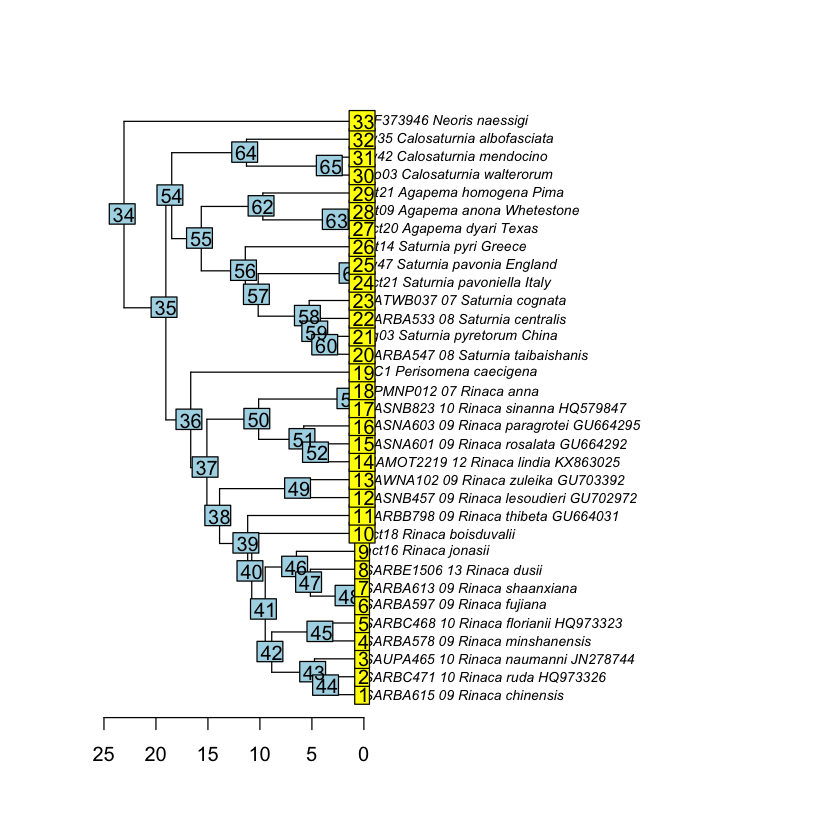

In [4]:
treefile = "20180606_Saturnia_BEAST_constrained2_ingroup_nocopaxa.nwk"
tree = read.tree(treefile)
plot(tree, cex=0.7)
axisPhylo() # plots timescale
nodelabels()
tiplabels(1:length(tree$tip.label))

# Three area DEC

## Load geography file

In [5]:
geogrfile = "Saturnia_geography.phy"
tipranges = getranges_from_LagrangePHYLIP(lgdata_fn=geogrfile)
moref(geogrfile)

33	3	(W E N)
jbt21_Agapema_homogena_Pima	001
jbt09_Agapema_anona_Whetestone	001
act20_Agapema_dyari_Texas	001
jbt14_Saturnia_pyri_Greece	100
act21_Saturnia_pavoniella_Italy	100
jw47_Saturnia_pavonia_England	100
SATWB037_07_Saturnia_cognata	010
cg03_Saturnia_pyretorum_China	010
SARBA547_08_Saturnia_taibaishanis	010
SARBA533_08_Saturnia_centralis	010
jw35_Calosaturnia_albofasciata	001
cjo03_Calosaturnia_walterorum	001
jw42_Calosaturnia_mendocino	001
AF373946_Neoris_naessigi	010
PC1_Perisomena_caecigena	100
SASNB457_09_Rinaca_lesoudieri_GU702972	010
SAWNA102_09_Rinaca_zuleika_GU703392	010
SASNB823_10_Rinaca_sinanna_HQ579847	010
SPMNP012_07_Rinaca_anna	010
MAMOT2219_12_Rinaca_lindia_KX863025	010
SASNA603_09_Rinaca_paragrotei_GU664295	010
SASNA601_09_Rinaca_rosalata_GU664292	010
act18_Rinaca_boisduvalii	010
act16_Rinaca_jonasii	010
SARBE1506_13_Rinaca_dusii	010
SARBA597_09_Rinaca_fujiana	010
SARBA613_09_Rinaca_shaanxiana	010
SARBC468_10_Rinaca_florianii_HQ973323	010
SARBA578_09_Rinaca_minsh

## Set max areas to be occupied at any time

In [16]:
max_range_size = 2

## Create states list

In [7]:
# http://phylo.wikidot.com/example-biogeobears-scripts#manual_modify_states

# Get your states list
areas = getareas_from_tipranges_object(tipranges)
states_list_0based = rcpp_areas_list_to_states_list(areas=areas, maxareas=max_range_size, include_null_range=TRUE)

# Make the list of ranges
ranges_list = NULL
for (i in 1:length(states_list_0based))
    {    
    if ( (length(states_list_0based[[i]]) == 1) && (is.na(states_list_0based[[i]])) )
        {
        tmprange = "_"
        } else {
        tmprange = paste(areas[states_list_0based[[i]]+1], collapse="")
        }
    ranges_list = c(ranges_list, tmprange)
    }

# Look at the ranges list
ranges_list
length(ranges_list)

#Remove nonadjacent areas
nonadjacent0=c("ES","WS")
keepTF0 = ranges_list %in% nonadjacent0 == FALSE

ranges_list_H0 = ranges_list[keepTF0]
ranges_list_H0
length(ranges_list_H0)

states_list_0based_H0 = states_list_0based[keepTF0]
length(states_list_0based_H0)

[1] "_"  "W"  "E"  "N"  "WE" "WN" "EN"

[1] 7

[1] "_"  "W"  "E"  "N"  "WE" "WN" "EN"

[1] 7

[1] 7

## Run three area DEC model

In [33]:
BioGeoBEARS_run_object = define_BioGeoBEARS_run() # DEC is default model
BioGeoBEARS_run_object = readfiles_BioGeoBEARS_run(BioGeoBEARS_run_object)
BioGeoBEARS_run_object$max_range_size = max_range_size
BioGeoBEARS_run_object$trfn = treefile
BioGeoBEARS_run_object$geogfn = geogrfile
BioGeoBEARS_run_object$min_branchlength = 0.000001    # Min to treat tip as a direct ancestor (no speciation event)
BioGeoBEARS_run_object$include_null_range = TRUE    # set to FALSE for e.g. DEC* model, DEC*+J, etc.
BioGeoBEARS_run_object$on_NaN_error = -1e50    # returns very low lnL if parameters produce NaN error (underflow check)
BioGeoBEARS_run_object$speedup = TRUE          # shorcuts to speed ML search; use FALSE if worried (e.g. >3 params)
BioGeoBEARS_run_object$use_optimx = TRUE    # if FALSE, use optim() instead of optimx()
BioGeoBEARS_run_object$num_cores_to_use = 4
BioGeoBEARS_run_object$force_sparse = FALSE    # force_sparse=TRUE causes pathology & isn't much faster at this scale
BioGeoBEARS_run_object$return_condlikes_table = TRUE
BioGeoBEARS_run_object$calc_TTL_loglike_from_condlikes_table = TRUE
BioGeoBEARS_run_object$calc_ancprobs = TRUE    # get ancestral states from optim run
BioGeoBEARS_run_object$BioGeoBEARS_model_object@params_table # show model parameter table
BioGeoBEARS_run_object$states_list = states_list_0based_H0
check_BioGeoBEARS_run(BioGeoBEARS_run_object) # check for errors in parameter settings

runslow = TRUE
resfn = "3DEC_H0.Rdata"
if (runslow)
    {
    res = bears_optim_run(BioGeoBEARS_run_object)
    res    

    save(res, file=resfn)
    res3DECH0 = res
    } else {
    # Loads to "res"
    load(resfn)
    res3DECH0 = res
    }

,type,init,min,max,est,note,desc
d,free,0.01000,1e-12,5.00000,0.01000,works,anagenesis: rate of 'dispersal' (range expansion)
e,free,0.01000,1e-12,5.00000,0.01000,works,anagenesis: rate of 'extinction' (range contraction)
a,fixed,0.00000,1e-12,5.00000,0.00000,works,anagenesis: rate of range-switching (i.e. for a standard char.)
b,fixed,1.00000,1e-12,1.00000,1.00000,non-stratified only,anagenesis: exponent on branch lengths
x,fixed,0.00000,-1e+01,10.00000,0.00000,works,"exponent on distance (modifies d, j, a)"
n,fixed,0.00000,-1e+01,10.00000,0.00000,works,"exponent on environmental distance (modifies d, j, a)"
w,fixed,1.00000,-1e+01,10.00000,1.00000,works,"exponent on manual dispersal multipliers (modifies d, j, a)"
u,fixed,0.00000,-1e+01,10.00000,0.00000,works,anagenesis: exponent on extinction risk with area (modifies e)
j,fixed,0.00000,1e-05,2.99999,0.00000,works,cladogenesis: relative per-event weight of jump dispersal
ysv,3-j,2.99999,1e-05,3.00000,2.99999,works,cladogenesis: y+s+v


[1] TRUE


Your computer has 4 cores.

Your computer has 4 cores. You have chosen to use:
num_cores_to_use = 4 cores for the matrix exponentiations in the likelihood calculations.
Started cluster with 4 cores.

[1] "parscale:"
[1] 1 1


NOTE: Before running optimx(), here is a test calculation of the data likelihood
using calc_loglike_for_optim() on initial parameter values...
if this crashes, the error messages are more helpful
than those from inside optimx().

     d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.996

calc_loglike_for_optim() on initial parameters loglike=-35.99646



Calculation of likelihood on initial parameters: successful.

Now starting Maximum Likelihood (ML) parameter optimization with optimx()...



Printing any warnings() that occurred during calc_loglike_for_optim():

NULL


Results of optimx:::scalecheck() below. Note: sometimes rescali

Warning message in (function (npt = min(n + 2L, 2L * n), rhobeg = NA, rhoend = NA, :
“unused control arguments ignored”

     d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.996
     d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.996
      d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.012 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -36.177
     d     e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.012 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -36.037
      d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.008 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.984
      d     e a b x n w u j ysv ys y s v mx0

## Plot 3 area DEC results

       LnL nparams          d            e j
1 -22.6153       2 0.00396947 4.196788e-05 0


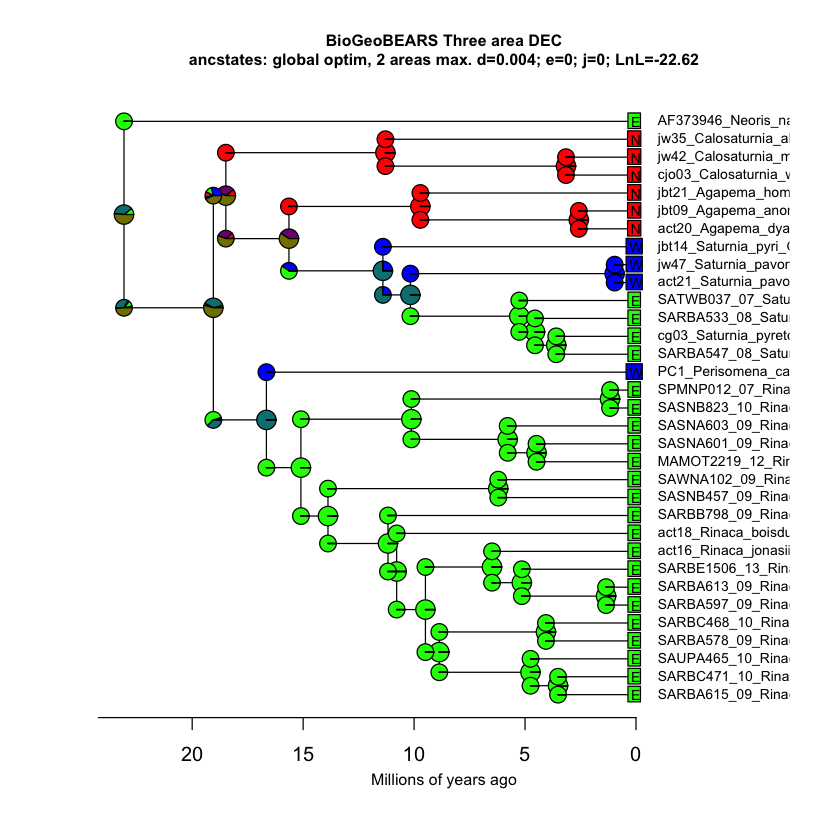

In [12]:
results_object = res3DECH0
analysis_titletxt ="BioGeoBEARS Three area DEC"
print(plot_BioGeoBEARS_results(results_object,
                               analysis_titletxt,
                               addl_params=list("j"),
                               plotwhat="pie",
                               label.offset=0.45,
                               tipcex=0.7,
                               statecex=0.7,
                               splitcex=0.6,
                               titlecex=0.8,
                               plotsplits=TRUE,
                               cornercoords_loc=scriptdir,
                               include_null_range=TRUE,
                               tr=tree,
                               tipranges=tipranges))

# Five area DEC

# Load geography file

In [15]:
geogrfile5 = "Saturnia_geography_5A.phy"
tipranges5 = getranges_from_LagrangePHYLIP(lgdata_fn=geogrfile5)
moref(geogrfile)

33	5	(W E N A B)
jbt21_Agapema_homogena_Pima	00100
jbt09_Agapema_anona_Whetestone	00100
act20_Agapema_dyari_Texas	00100
jbt14_Saturnia_pyri_Greece	10000
act21_Saturnia_pavoniella_Italy	10000
jw47_Saturnia_pavonia_England	10000
SATWB037_07_Saturnia_cognata	01000
cg03_Saturnia_pyretorum_China	01000
SARBA547_08_Saturnia_taibaishanis	01000
SARBA533_08_Saturnia_centralis	01000
jw35_Calosaturnia_albofasciata	00100
cjo03_Calosaturnia_walterorum	00100
jw42_Calosaturnia_mendocino	00100
AF373946_Neoris_naessigi	01000
PC1_Perisomena_caecigena	10000
SASNB457_09_Rinaca_lesoudieri_GU702972	01000
SAWNA102_09_Rinaca_zuleika_GU703392	01000
SASNB823_10_Rinaca_sinanna_HQ579847	01000
SPMNP012_07_Rinaca_anna	01000
MAMOT2219_12_Rinaca_lindia_KX863025	01000
SASNA603_09_Rinaca_paragrotei_GU664295	01000
SASNA601_09_Rinaca_rosalata_GU664292	01000
act18_Rinaca_boisduvalii	01000
act16_Rinaca_jonasii	01000
SARBE1506_13_Rinaca_dusii	01000
SARBA597_09_Rinaca_fujiana	01000
SARBA613_09_Rinaca_shaanxiana	01000
SARBC468

# Create states list

In [23]:
# http://phylo.wikidot.com/example-biogeobears-scripts#manual_modify_states

# Get your states list
areas = getareas_from_tipranges_object(tipranges5)
states_list_0based = rcpp_areas_list_to_states_list(areas=areas, maxareas=max_range_size, include_null_range=TRUE)

# Make the list of ranges
ranges_list = NULL
for (i in 1:length(states_list_0based))
    {    
    if ( (length(states_list_0based[[i]]) == 1) && (is.na(states_list_0based[[i]])) )
        {
        tmprange = "_"
        } else {
        tmprange = paste(areas[states_list_0based[[i]]+1], collapse="")
        }
    ranges_list = c(ranges_list, tmprange)
    }

# Look at the ranges list
ranges_list
length(ranges_list)

#Remove nonadjacent areas
nonadjacent5=c("WN","WB","EN","EA","AB")
keepTF5 = ranges_list %in% nonadjacent5 == FALSE

ranges_list_H5 = ranges_list[keepTF5]
ranges_list_H5
length(ranges_list_H5)

states_list_0based_H5 = states_list_0based[keepTF5]
length(states_list_0based_H5)

[1] "_"  "W"  "E"  "N"  "A"  "B"  "WE" "WN" "WA" "WB" "EN" "EA" "EB" "NA" "NB"
[16] "AB"

[1] 16

[1] "_"  "W"  "E"  "N"  "A"  "B"  "WE" "WA" "EB" "NA" "NB"

[1] 11

[1] 11

# Run five area DEC model

In [24]:
BioGeoBEARS_run_object = define_BioGeoBEARS_run() # DEC is default model
BioGeoBEARS_run_object = readfiles_BioGeoBEARS_run(BioGeoBEARS_run_object)
BioGeoBEARS_run_object$max_range_size = max_range_size
BioGeoBEARS_run_object$trfn = treefile
BioGeoBEARS_run_object$geogfn = geogrfile
BioGeoBEARS_run_object$min_branchlength = 0.000001    # Min to treat tip as a direct ancestor (no speciation event)
BioGeoBEARS_run_object$include_null_range = TRUE    # set to FALSE for e.g. DEC* model, DEC*+J, etc.
BioGeoBEARS_run_object$on_NaN_error = -1e50    # returns very low lnL if parameters produce NaN error (underflow check)
BioGeoBEARS_run_object$speedup = TRUE          # shorcuts to speed ML search; use FALSE if worried (e.g. >3 params)
BioGeoBEARS_run_object$use_optimx = TRUE    # if FALSE, use optim() instead of optimx()
BioGeoBEARS_run_object$num_cores_to_use = 4
BioGeoBEARS_run_object$force_sparse = FALSE    # force_sparse=TRUE causes pathology & isn't much faster at this scale
BioGeoBEARS_run_object$return_condlikes_table = TRUE
BioGeoBEARS_run_object$calc_TTL_loglike_from_condlikes_table = TRUE
BioGeoBEARS_run_object$calc_ancprobs = TRUE    # get ancestral states from optim run
BioGeoBEARS_run_object$BioGeoBEARS_model_object@params_table # show model parameter table
BioGeoBEARS_run_object$states_list = states_list_0based_H5
check_BioGeoBEARS_run(BioGeoBEARS_run_object) # check for errors in parameter settings

runslow = TRUE
resfn = "5DEC_H0.Rdata"
if (runslow)
    {
    res = bears_optim_run(BioGeoBEARS_run_object)
    res    

    save(res, file=resfn)
    res5DECH0 = res
    } else {
    # Loads to "res"
    load(resfn)
    res5DECH0 = res
    }

,type,init,min,max,est,note,desc
d,free,0.01000,1e-12,5.00000,0.01000,works,anagenesis: rate of 'dispersal' (range expansion)
e,free,0.01000,1e-12,5.00000,0.01000,works,anagenesis: rate of 'extinction' (range contraction)
a,fixed,0.00000,1e-12,5.00000,0.00000,works,anagenesis: rate of range-switching (i.e. for a standard char.)
b,fixed,1.00000,1e-12,1.00000,1.00000,non-stratified only,anagenesis: exponent on branch lengths
x,fixed,0.00000,-1e+01,10.00000,0.00000,works,"exponent on distance (modifies d, j, a)"
n,fixed,0.00000,-1e+01,10.00000,0.00000,works,"exponent on environmental distance (modifies d, j, a)"
w,fixed,1.00000,-1e+01,10.00000,1.00000,works,"exponent on manual dispersal multipliers (modifies d, j, a)"
u,fixed,0.00000,-1e+01,10.00000,0.00000,works,anagenesis: exponent on extinction risk with area (modifies e)
j,fixed,0.00000,1e-05,2.99999,0.00000,works,cladogenesis: relative per-event weight of jump dispersal
ysv,3-j,2.99999,1e-05,3.00000,2.99999,works,cladogenesis: y+s+v


[1] TRUE


Your computer has 4 cores.

Your computer has 4 cores. You have chosen to use:
num_cores_to_use = 4 cores for the matrix exponentiations in the likelihood calculations.
Started cluster with 4 cores.

[1] "parscale:"
[1] 1 1


NOTE: Before running optimx(), here is a test calculation of the data likelihood
using calc_loglike_for_optim() on initial parameter values...
if this crashes, the error messages are more helpful
than those from inside optimx().

     d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.996

calc_loglike_for_optim() on initial parameters loglike=-35.99646



Calculation of likelihood on initial parameters: successful.

Now starting Maximum Likelihood (ML) parameter optimization with optimx()...



Printing any warnings() that occurred during calc_loglike_for_optim():

NULL


Results of optimx:::scalecheck() below. Note: sometimes rescali

Warning message in (function (npt = min(n + 2L, 2L * n), rhobeg = NA, rhoend = NA, :
“unused control arguments ignored”

     d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.996
     d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.996
      d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.012 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -36.177
     d     e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.01 0.012 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -36.037
      d    e a b x n w u j ysv ys y s v mx01 mx01j mx01y mx01s mx01v mx01r  mf
1 0.008 0.01 0 1 0 0 1 0 0   3  2 1 1 1    0     0     0     0     0   0.5 0.1
  dp fdp     LnL
1  1   0 -35.984
      d     e a b x n w u j ysv ys y s v mx0

## Plot 5 area DEC results

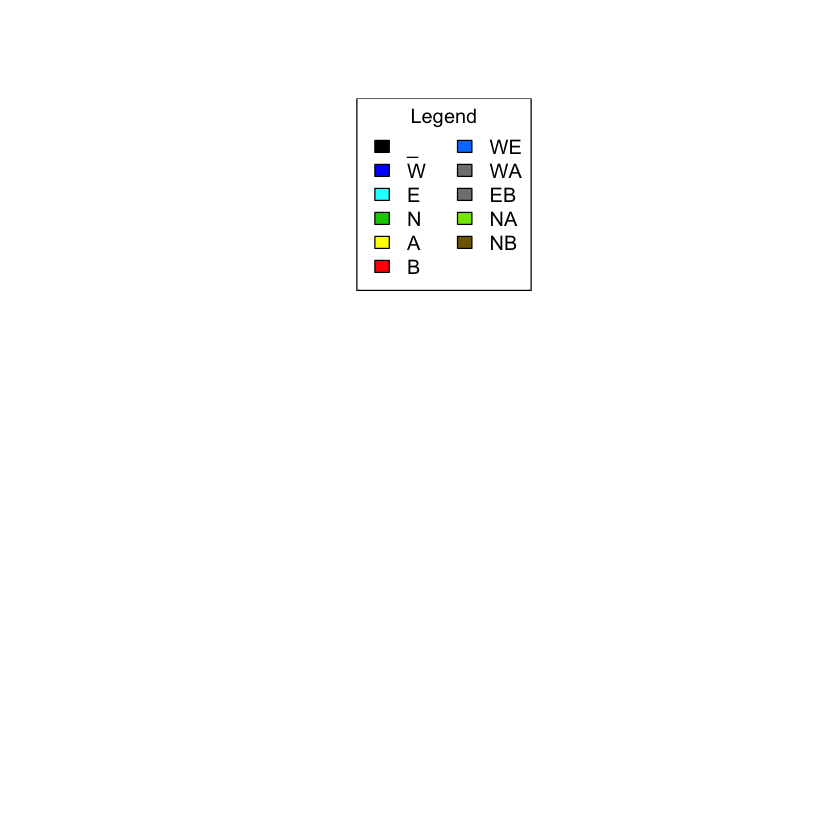

        LnL nparams           d           e j
1 -35.96387       2 0.008830928 0.009855207 0


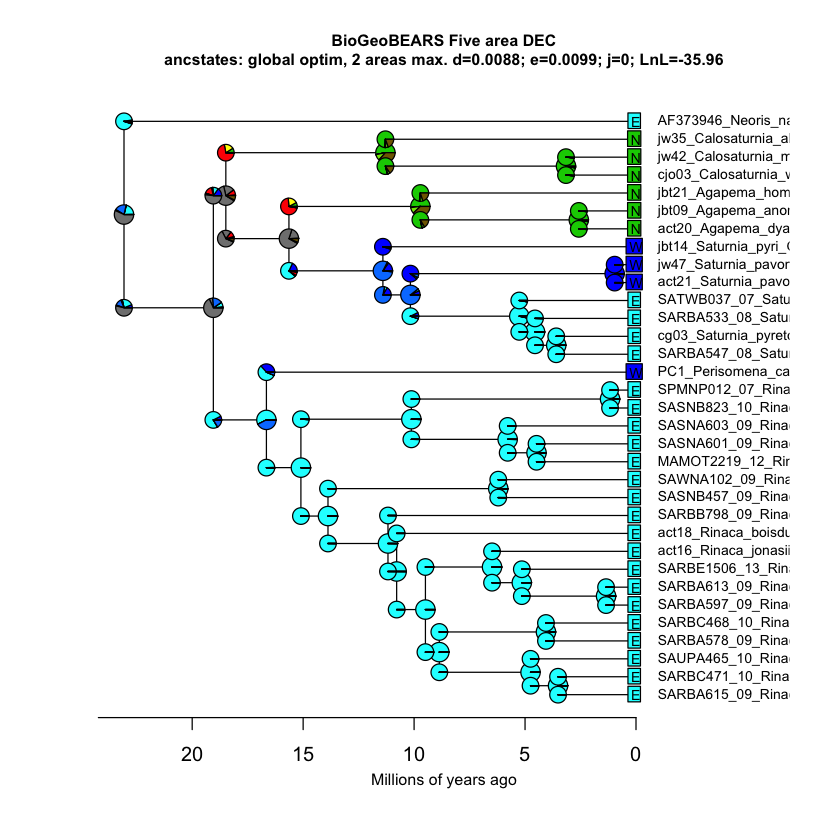

In [34]:
results_object = res5DECH0
analysis_titletxt ="BioGeoBEARS Five area DEC"
print(plot_BioGeoBEARS_results(results_object,
                               analysis_titletxt,
                               addl_params=list("j"),
                               plotwhat="pie",
                               label.offset=0.45,
                               tipcex=0.7,
                               statecex=0.7,
                               splitcex=0.6,
                               titlecex=0.8,
                               plotsplits=TRUE,
                               plotlegend=TRUE,
                               cornercoords_loc=scriptdir,
                               include_null_range=TRUE,
                               tr=tree,
                               tipranges=tipranges5))

### Table with marginal prob for each state and node

In [32]:
# see http://phylo.wikidot.com/example-biogeobears-scripts#working
# You can see that in this table, nrows = number of nodes
# (tips+internal), and ncols = number of states (= number 
# of possible ranges).
#
# The rows are in the order of APE's default node numbering
# scheme:
#
# Node number (and then interpretation)
# 1-ntips = tip node numbers
# ntips+1 = root node number
# (ntips+1):(ntips+num_internal_nodes) = internal node numbers

round(res3DECH0$ML_marginal_prob_each_state_at_branch_top_AT_node, 2)
#write.csv(Nodeprobs, file = "DECJ_Nodeprobs.csv")

# this one displays the results for each corner:
#resDEC$ML_marginal_prob_each_state_at_branch_bottom_below_node

0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0
0,0,1,0,0,0,0


# Test for best model fit

In [31]:
# set up empty tables to hold the results
restable = NULL
teststable = NULL

# 3DEC vs 5DEC
# extract log likelihood from model results
LnL_1 = get_LnL_from_BioGeoBEARS_results_object(res3DECH0)
LnL_2 = get_LnL_from_BioGeoBEARS_results_object(res5DECH0)

numparams1 = 2
numparams2 = 2
stats = AICstats_2models(LnL_1, LnL_2, numparams2, numparams2)

# DEC, null model for Likelihood Ratio Test (LRT)
res2 = extract_params_from_BioGeoBEARS_results_object(results_object=res3DECH0, 
                                                      returnwhat="table", 
                                                      addl_params=c("j"), 
                                                      paramsstr_digits=4)
# DEC constrained, alternative model for Likelihood Ratio Test (LRT)
res1 = extract_params_from_BioGeoBEARS_results_object(results_object=res5DECH0, 
                                                      returnwhat="table", 
                                                      addl_params=c("j"), 
                                                      paramsstr_digits=4)
rbind(res2, res1)
tmp_tests = conditional_format_table(stats)
restable = rbind(restable, res2, res1)
teststable = rbind(teststable, tmp_tests)

teststable


LnL,numparams,d,e,j
-22.61530,2,0.003969470,4.196788e-05,0
-35.96387,2,0.008830928,9.855207e-03,0


alt,null,LnLalt,LnLnull,DFalt,DFnull,DF,Dstatistic,pval,test,tail,AIC1,AIC2,AICwt1,AICwt2,AICweight_ratio_model1,AICweight_ratio_model2
,,-22.62,-35.96,2,2,0,26.7,0,chi-squared,one-tailed,49.23,75.93,1.00,1.6e-06,626923,1.6e-06
